# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
#!pip -q install ./python

In [2]:
path20 = r"C:\Users\adith\Desktop\Meng Robotics\reinforcement\Banana\Cont-Control\Unity-ml-env-arm\20agents\Reacher_Windows_x86_64\Reacher"

path1 = r"C:\Users\adith\Desktop\Meng Robotics\reinforcement\Banana\Cont-Control\Unity-ml-env-arm\Reacher_Windows_x86_64\Reacher"

In [3]:
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt

The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [4]:


# select this option to load version 1 (with a single agent) of the environment
#env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')
env = UnityEnvironment(file_name=path20)
# select this option to load version 2 (with 20 agents) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [7]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.16549999630078674


In [8]:
import numpy as np
import random
import copy
from collections import namedtuple, deque

from model import Actor, Critic

import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 128      # minibatch size

GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters

LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic

WEIGHT_DECAY = 0.000   # L2 weight decay

UpdateCount = 2 # after these no of times the update to the neural net takes place 
UpdateNo = 5 # no of updates per time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("the device that will be used is ", device)
class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        self.updateCounter = UpdateCount

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        print("actor model been used ..", self.actor_local)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        print("critic model which is used .." , self.critic_local)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise((num_agents,action_size), random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
    
    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        for s,a,r,n_s,d in zip(state,action,reward,next_state,done):
            self.memory.add(s, a, r, n_s, d)
            
        self.updateCounter -=1
        #print(self.updateCounter)
        
        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE and self.updateCounter <= 0:
            #print("updating")
            self.updateCounter = UpdateCount
            for _ in range(UpdateNo):
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
           #print("actions size here" , actions)
        self.actor_local.train()
        if add_noise:
            #print("noise check", self.noise.sample())
            action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        #critic_loss = F.mse_loss(Q_expected, Q_targets)
        critic_loss = F.smooth_l1_loss(Q_expected, Q_targets)
        
        # Minimize the loss
        self.critic_optimizer.zero_grad()
    
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        #print("hello")
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actor_local.parameters(), 1)
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.size = size
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        #print(e)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

the device that will be used is  cuda:0


In [9]:
agent = Agent(state_size, action_size, random_seed=0)

actor model been used .. Actor(
  (fc1): Linear(in_features=33, out_features=512, bias=True)
  (fch2): Linear(in_features=512, out_features=512, bias=True)
  (fch3): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=4, bias=True)
)
critic model which is used .. Critic(
  (fcs1): Linear(in_features=33, out_features=512, bias=True)
  (fc2): Linear(in_features=516, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=1, bias=True)
)


In [21]:
from torchsummary import summary
summary(agent.actor_local ,(33 , ))
summary(agent.critic_local ,(37,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]          17,408
            Linear-2                  [-1, 512]         262,656
            Linear-3                  [-1, 512]         262,656
            Linear-4                    [-1, 4]           2,052
Total params: 544,772
Trainable params: 544,772
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.08
Estimated Total Size (MB): 2.09
----------------------------------------------------------------


TypeError: forward() missing 1 required positional argument: 'action'

Episode 10	Average Score: 2.52	Score: 8.58 Tcount:10000

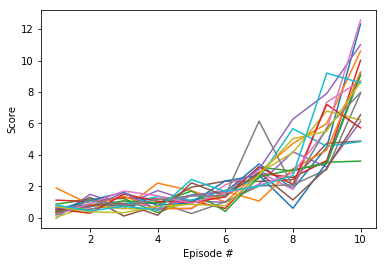

Episode 20	Average Score: 10.85	Score: 36.54 Tcount:20000

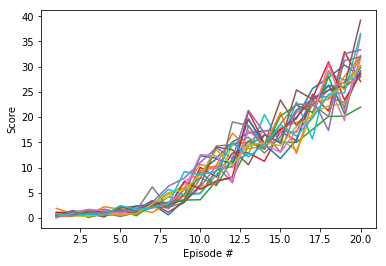

Episode 30	Average Score: 19.06	Score: 34.50 Tcount:30000

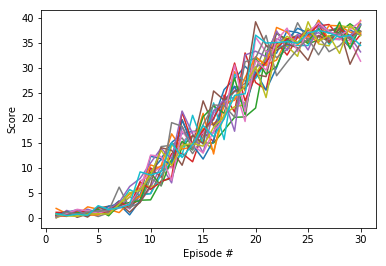

Episode 40	Average Score: 23.69	Score: 35.45 Tcount:40000

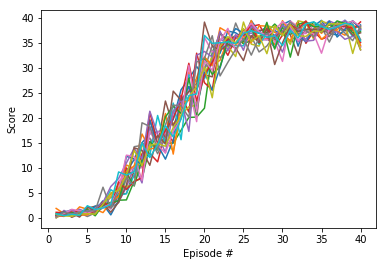

Episode 50	Average Score: 26.51	Score: 38.27 Tcount:50000

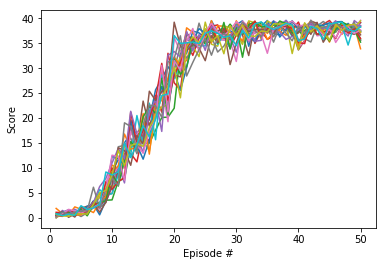

Episode 60	Average Score: 28.44	Score: 39.58 Tcount:60000

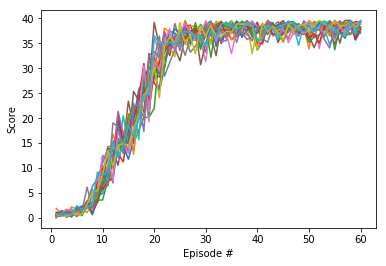

Episode 70	Average Score: 29.80	Score: 37.32 Tcount:70000

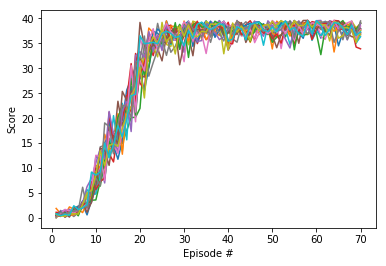

Episode 80	Average Score: 30.84	Score: 37.96 Tcount:80000

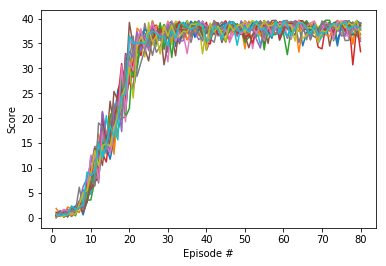

Episode 90	Average Score: 31.57	Score: 38.70 Tcount:90000

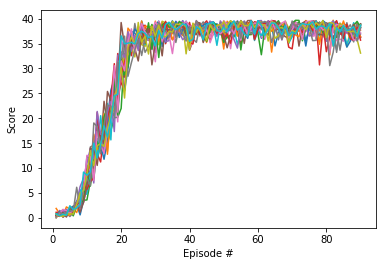

Episode 97	Average Score: 32.03	Score: 39.01 Tcount:97000


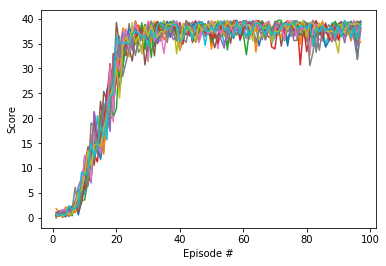

In [10]:
Scores_all = []
def ddpg(n_episodes=2000 , max_t = 1000):
    scores_deque = deque(maxlen=100)
    scores = []
    max_score = -np.Inf
    t_count = 0
    t = 0
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations
        agent.reset()
        score = np.zeros((num_agents,))
        while(t < max_t):
            t+=1
            action = agent.act(state)
            #print("actions given",action)
            #print(action)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations       # get next state (for each agent)
            reward = env_info.rewards                       # get reward (for each agent)
            done = env_info.local_done                      # see if episode finished
            #print(env_info.rewards)
            score += np.array(env_info.rewards)             # update the score (for each agent)    
            agent.step(state, action, reward, next_state, done)
            state = next_state
            t_count+=1
            if np.any(done):
                break
        t =0
        scores_deque.append(score)
        scores.append(score)
        Scores_all = scores
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f} Tcount:{}'.format(i_episode, np.mean(scores_deque), score[-1],t_count), end="")
        if np.mean(scores_deque) > 32 :
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            return scores
            
            
        if i_episode % 10 == 0 and i_episode != 0:
            fig = plt.figure()
            ax = fig.add_subplot(111)
            plt.plot(np.arange(1, len(scores)+1), scores)
            plt.ylabel('Score')
            plt.xlabel('Episode #')
            plt.show()
    return scores

scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Episode 134	Average Score: 32.03
(97, 20)


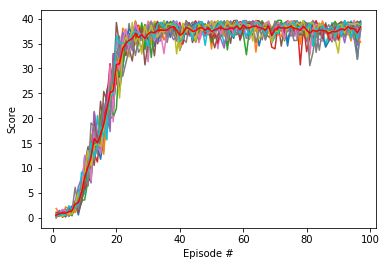

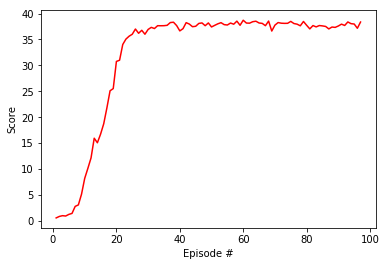

In [17]:
# torch.save(agent.actor_local.state_dict(), 'checkpoint_actorNow.pth')
# torch.save(agent.critic_local.state_dict(), 'checkpoint_criticNow.pth')
print('\rEpisode {}\tAverage Score: {:.2f}'.format(134, np.mean(scores)))
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
print(np.shape(scores))
plt.plot(np.arange(1, len(scores)+1), np.mean(np.array(scores) , axis = 1) , 'r')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()


fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), np.mean(np.array(scores) , axis = 1) , 'r')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [22]:
#agent.actor_local.load_state_dict(torch.load('checkpoint_actor-TrainingSucess-one1.pth'))
#agent.actor_local.load_state_dict(torch.load('checkpoint_actorNow.pth'))

agent.actor_local

Actor(
  (fc1): Linear(in_features=33, out_features=512, bias=True)
  (fch2): Linear(in_features=512, out_features=512, bias=True)
  (fch3): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=4, bias=True)
)

In [23]:
env_info = env.reset(train_mode=False)[brain_name]

In [24]:
print(env_info)

In [ ]:
# load the weights from file
# env = UnityEnvironment(file_name=path)
env_info = env.reset(train_mode=False)[brain_name]
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
state = env_info.vector_observations
score =np.zeros(num_agents)
all_score= np.array([])
for i in range(3):
    env_info = env.reset(train_mode=False)[brain_name]
    state = env_info.vector_observations
    print("current score is ", score)
    for j in range(1000):
        #print(state)
        action = agent.act(state)
        #action = np.int32(action)
        env_info = env.step(action)[brain_name]
        next_state = env_info.vector_observations
        reward = env_info.rewards
        done = env_info.local_done
        state = next_state
        score += np.array(reward)
        if np.any(done) or j >= 999:
            break
print(score)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

current score is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 